Using device: cuda


/home/antonin-rottman/anaconda3/envs/ml_env/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/antonin-rottman/anaconda3/envs/ml_env/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/antonin-rottman/anaconda3/envs/ml_env/lib/python3.10/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Ours PPO:   0%|          | 0/600 [00:00<?, ?ep/s]

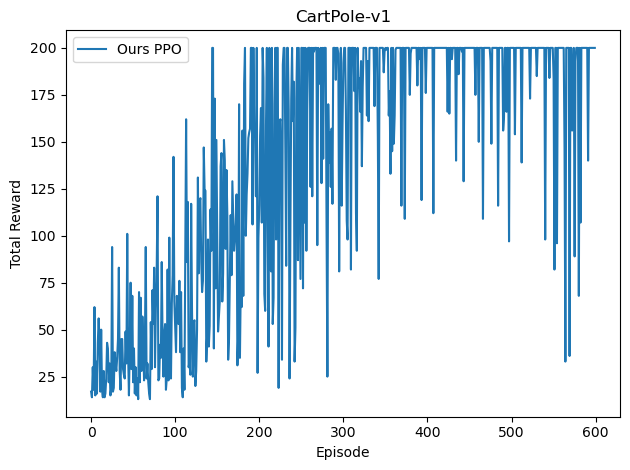

In [ ]:
#!/usr/bin/env python3
import numpy as np
# patch for NumPy 2.0: restore removed aliases
np.float_ = np.float64
np.bool8 = np.bool_

import random
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import gym
import gymnasium as gym_sb3
from stable_baselines3 import PPO as SB3_PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
from tqdm.auto import tqdm



# --------------------------------------------------------------------------- #
# Fix all seeds for reproducibility
# --------------------------------------------------------------------------- #
base_seed = 12345
random.seed(base_seed)
np.random.seed(base_seed)
torch.manual_seed(base_seed)
torch.cuda.manual_seed_all(base_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

# --------------------------------------------------------------------------- #
# Device (GPU if available)
# --------------------------------------------------------------------------- #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --------------------------------------------------------------------------- #
# MLP architecture settings
# --------------------------------------------------------------------------- #
MLP_LAYERS = [256,]

# --------------------------------------------------------------------------- #
# Rollout Buffer for PPO
# --------------------------------------------------------------------------- #
class RolloutBuffer:
    def __init__(self):
        self.states       = []
        self.actions      = []
        self.logprobs     = []
        self.rewards      = []
        self.state_vals   = []
        self.is_terminals = []

    def clear(self):
        del self.states[:]
        del self.actions[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_vals[:]
        del self.is_terminals[:]

# --------------------------------------------------------------------------- #
# Actor-Critic network with MLP_LAYERS architecture
# --------------------------------------------------------------------------- #
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        # actor trunk
        actor_layers = []
        last_dim = state_dim
        for h in MLP_LAYERS:
            actor_layers.append(nn.Linear(last_dim, h))
            actor_layers.append(nn.ReLU())
            last_dim = h
        actor_layers.append(nn.Linear(last_dim, action_dim))
        actor_layers.append(nn.Softmax(dim=-1))
        self.actor = nn.Sequential(*actor_layers)
        # critic trunk
        critic_layers = []
        last_dim = state_dim
        for h in MLP_LAYERS:
            critic_layers.append(nn.Linear(last_dim, h))
            critic_layers.append(nn.ReLU())
            last_dim = h
        critic_layers.append(nn.Linear(last_dim, 1))
        self.critic = nn.Sequential(*critic_layers)

    def act(self, state):
        probs  = self.actor(state)
        dist   = Categorical(probs)
        action = dist.sample()
        return action, dist.log_prob(action), self.critic(state), dist.entropy()

    def evaluate(self, states, actions):
        probs      = self.actor(states)
        dist       = Categorical(probs)
        logprobs   = dist.log_prob(actions)
        entropy    = dist.entropy()
        state_vals = self.critic(states).squeeze(-1)
        return logprobs, state_vals, entropy

# --------------------------------------------------------------------------- #
# PPO Agent with GAE and entropy bonus
# ---------------------------------
class PPOAgent:
    def __init__(
        self,
        state_dim,
        action_dim,
        lr_actor     = 3e-4,
        lr_critic    = 1e-3,
        gamma        = 0.99,
        K_epochs     = 4,
        eps_clip     = 0.2,
        rollout_size = 2048,
        ent_coef     = 0.02,
        gae_lambda   = 0.95,
        seed         = 12345,
    ):
        # reproducibility
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        self.gamma        = gamma
        self.eps_clip     = eps_clip
        self.K_epochs     = K_epochs
        self.rollout_size = rollout_size
        self.ent_coef     = ent_coef
        self.gae_lambda   = gae_lambda
        self.buffer       = RolloutBuffer()

        self.policy     = ActorCritic(state_dim, action_dim).to(device)
        self.policy_old = copy.deepcopy(self.policy)
        self.optimizer  = torch.optim.Adam([
            {'params': self.policy.actor.parameters(),  'lr': lr_actor},
            {'params': self.policy.critic.parameters(), 'lr': lr_critic},
        ])
        self.MseLoss = nn.MSELoss()

    def select_action(self, state):
        state = torch.FloatTensor(state).to(device)
        # sample action from old policy without tracking gradients
        with torch.no_grad():
            action, logprob, state_val, _ = self.policy_old.act(state)
        # detach tensors to avoid reusing graph
        state     = state.detach()
        action    = action.detach()
        logprob   = logprob.detach()
        state_val = state_val.detach()
        # store
        self.buffer.states.append(state)
        self.buffer.actions.append(action)
        self.buffer.logprobs.append(logprob)
        self.buffer.state_vals.append(state_val)
        return action.item()

    def record_reward(self, reward, done):
        self.buffer.rewards.append(reward)
        self.buffer.is_terminals.append(done)

    def update(self):
        # prepare data
        rewards = self.buffer.rewards
        dones   = self.buffer.is_terminals
        states  = torch.stack(self.buffer.states).to(device)
        actions = torch.stack(self.buffer.actions).to(device)
        old_logps = torch.stack(self.buffer.logprobs).to(device).detach()

        # compute bootstrap values
        vals = torch.stack(self.buffer.state_vals).squeeze(-1).cpu().numpy().tolist()
        vals.append(0.0)

        # GAE advantage estimation
        advantages = []
        gae = 0.0
        for t in reversed(range(len(rewards))):
            mask  = 1.0 - float(dones[t])
            delta = rewards[t] + self.gamma * vals[t+1] * mask - vals[t]
            gae   = delta + self.gamma * self.gae_lambda * mask * gae
            advantages.insert(0, gae)
        advantages = torch.tensor(advantages, dtype=torch.float32).to(device)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-7)

        # detach old value estimates for return calculation
        old_vals = torch.tensor(vals[:-1], dtype=torch.float32).to(device)
        returns  = advantages + old_vals

        # PPO update epochs
        for _ in range(self.K_epochs):
            logps, state_vals, entropy = self.policy.evaluate(states, actions)
            ratios = torch.exp(logps - old_logps)
            surr1  = ratios * advantages
            surr2  = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            actor_loss   = -torch.min(surr1, surr2).mean()
            critic_loss  = self.MseLoss(state_vals, returns)
            entropy_loss = -entropy.mean()
            loss = actor_loss + 0.5 * critic_loss + self.ent_coef * entropy_loss

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        # sync old policy and clear buffer
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.buffer.clear()

# --------------------------------------------------------------------------- #
# Callback for logging SB3 rewards
# --------------------------------------------------------------------------- #
class EpisodeRewardLogger(BaseCallback):
    def __init__(self):
        super().__init__()
        self.rewards = []
    def _on_step(self) -> bool:
        for info in self.locals.get("infos", []):
            if "episode" in info:
                self.rewards.append(info["episode"]["r"])
        return True

# --------------------------------------------------------------------------- #
# Training functions
# --------------------------------------------------------------------------- #
def train_ours_ppo(
    env_id,
    episodes       = 600,
    max_steps      = 500,
    seed           = 12345,
    lr_actor       = 3e-4,
    lr_critic      = 1e-3,
    gamma          = 0.99,
    K_epochs       = 4,
    eps_clip       = 0.2,
    rollout_size   = 1024,
    ent_coef       = 0.02,
    gae_lambda     = 0.95,
):
    from gym.wrappers import TimeLimit

    env = gym.make(env_id)
    if env_id == "MountainCar-v0":
        env = TimeLimit(env.unwrapped, max_episode_steps=10_000)
    env.seed(seed)
    env.action_space.seed(seed)
    np.random.seed(seed)

    state_dim  = env.observation_space.shape[0]
    action_dim = env.action_space.n
    agent = PPOAgent(
        state_dim, action_dim,
        lr_actor   = lr_actor,
        lr_critic  = lr_critic,
        gamma      = gamma,
        K_epochs   = K_epochs,
        eps_clip   = eps_clip,
        rollout_size=rollout_size,
        ent_coef   = ent_coef,
        gae_lambda = gae_lambda,
        seed       = seed,
    )

    returns = []
    for ep in tqdm(range(episodes), desc="Ours PPO", unit="ep"):
        state, ep_ret = env.reset(), 0
        for t in range(max_steps):
            action = agent.select_action(state)
            state, reward, done, _ = env.step(action)
            agent.record_reward(reward, done)
            ep_ret += reward

            if len(agent.buffer.states) >= rollout_size or done:
                agent.update()
            if done:
                break
        returns.append(ep_ret)
    return returns



def train_sb3_ppo(env_id, episodes, max_steps_override):
    env0 = gym_sb3.make(env_id)
    if max_steps_override is not None:
        try:
            env0.unwrapped._max_episode_steps = max_steps_override
        except:
            env0._max_episode_steps = max_steps_override
    env_sb3 = Monitor(env0)
    env_sb3.reset(seed=base_seed)
    env_sb3.action_space.seed(base_seed)

    max_steps   = getattr(env_sb3.env, "_max_episode_steps", env_sb3.env.spec.max_episode_steps)
    total_steps = episodes * max_steps

    model  = SB3_PPO("MlpPolicy", env_sb3, verbose=0, seed=base_seed, device=device)
    logger = EpisodeRewardLogger()
    model.learn(total_timesteps=total_steps, callback=logger)

    return logger.rewards[:episodes]

# --------------------------------------------------------------------------- #
# Main: train and plot
# --------------------------------------------------------------------------- #
def main():
    # envs   = [  "Acrobot-v1" ,"CartPole-v1",] #
    envs = ["CartPole-v1","Acrobot-v1","MountainCar-v0"]

    for env_id in envs:
        ours_returns = train_ours_ppo(
            env_id       = env_id,
            episodes     = 600,
            max_steps    = 200,      # 10000 for MountainCar
            seed         = 42,

            # PPO hyper‐params
            lr_actor     = 1e-4,
            lr_critic    = 5e-4,
            gamma        = 0.995,
            K_epochs     = 8,
            eps_clip     = 0.10,   #1.0 for MountainCar
            rollout_size = 2048,
            ent_coef     = 0.001,  #1.0 for MountainCar
            gae_lambda   = 0.98,
        )

        plt.figure()
        plt.plot(ours_returns, label="Ours PPO")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title(env_id)
        plt.legend()
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    main()
